# Trabajo Practico N° 2
**Materia:** Minería de datos

**Año:** 2025

**Integrantes:** Juana Chies Doumecq, Nicolas Mancini


In [404]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split

# Arboles de desición
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

#Bayes
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

# Métricas
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, mean_absolute_error,
                             mean_squared_error)

from sklearn.metrics import (roc_curve, auc, confusion_matrix, accuracy_score,
                             precision_score, recall_score,
                             ConfusionMatrixDisplay)

In [405]:
def tableResult(label, prediction):
    table = pd.DataFrame({'Actual':label, 'Predicted':prediction})
    return table

# Primer dataset

In [406]:
dataset1 = pd.read_csv('1000_Companies.csv')

## Análisis exploratorio de datos (EDA)

In [407]:
#Creamos copia del dataset original
df1 = dataset1.copy()

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       1000 non-null   float64
 1   Administration  1000 non-null   float64
 2   MarketingSpend  1000 non-null   float64
 3   State           1000 non-null   object 
 4   Profit          1000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 39.2+ KB


In [408]:
df1.head()

,RyD_Spend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


**Valores duplicados**

In [409]:
df1.duplicated().values.any()

True

In [410]:
df1 = df1.drop_duplicates()

**Valores faltantes**

In [411]:
df1.isna().sum()

RyD_Spend         0
Administration    0
MarketingSpend    0
State             0
Profit            0
dtype: int64

**Distrubuciones y correlación de las variables**

In [412]:
#Selección de columnas númericas
cols1 = ['RyD_Spend', 'Administration', 'MarketingSpend', 'Profit']

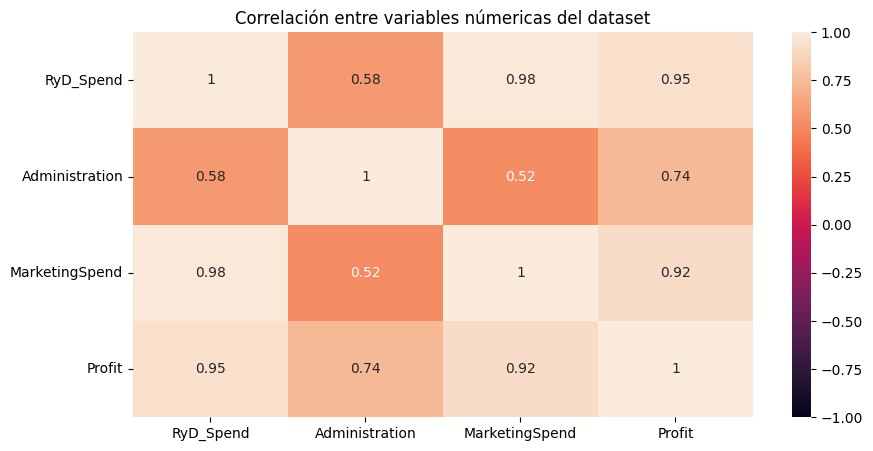

In [413]:
plt.figure(figsize=(10,5))
sns.heatmap(df1[cols1].corr(), vmin=-1, vmax=1, annot=True)
plt.title('Correlación entre variables númericas del dataset')
plt.show()

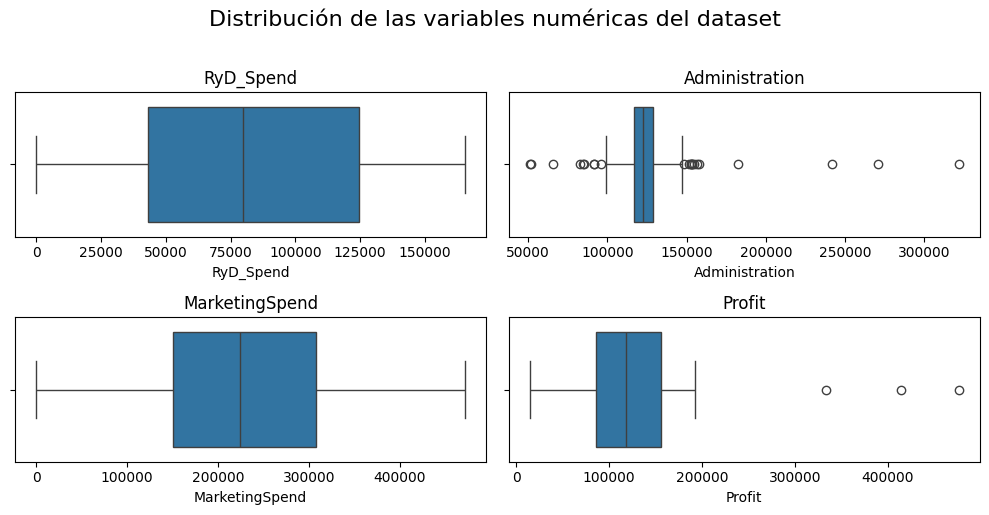

In [414]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

axes = axes.flatten()

for i, col in enumerate(cols1):
    sns.boxplot(x=df1[col], ax=axes[i], orient='h')
    axes[i].set_title(col)

fig.suptitle('Distribución de las variables numéricas del dataset', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

**Outliers**

In [415]:
df1 = df1[df1['Profit'] < df1['Profit'].quantile(0.997)]

In [416]:
df1 = df1[df1['Administration'] < df1['Administration'].quantile(0.99)]

**Codificación de variables catgorícas**

In [417]:
df1 = pd.get_dummies(data=df1, columns=['State'])

df1

,RyD_Spend,Administration,MarketingSpend,Profit,State_California,State_Florida,State_New York
0,165349.20,136897.8000,471784.1000,192261.83000,False,False,True
2,153441.51,101145.5500,407934.5400,191050.39000,False,True,False
3,144372.41,118671.8500,383199.6200,182901.99000,False,False,True
4,142107.34,91391.7700,366168.4200,166187.94000,False,True,False
5,131876.90,99814.7100,362861.3600,156991.12000,False,False,True
...,...,...,...,...,...,...,...
992,105127.00,125982.7298,271621.8728,138841.98810,False,True,False
993,46798.00,117368.4374,159075.9080,89012.02672,True,False,False
994,97209.00,124813.3635,256344.0701,132077.70900,False,False,True
995,54135.00,118451.9990,173232.6695,95279.96251,True,False,False


In [418]:
df1.columns

Index(['RyD_Spend', 'Administration', 'MarketingSpend', 'Profit',
       'State_California', 'State_Florida', 'State_New York'],
      dtype='object')

**División test - train**

In [419]:
cols_bool = ['State_California', 'State_Florida', 'State_New York']
cols_num = ['RyD_Spend', 'Administration', 'MarketingSpend']

X1 = df1.drop(columns=['Profit'])
y1 = df1['Profit']

X1[cols_bool] = X1[cols_bool].astype('int')

In [420]:
X_train1, X_test1, y_train1, y_test1  = train_test_split(X1, y1, test_size=0.2, random_state=13, shuffle=True)

## Árbol de decisión

In [421]:
tree_reg = DecisionTreeRegressor(max_depth=3, criterion='squared_error',
                                 min_samples_leaf=1, min_samples_split=2,
                                 random_state=13)

tree_reg.fit(X_train1, y_train1)

,criterion,'squared_error'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


**Optimización del árbol**

In [422]:
param_grid = {
    'max_depth': [5, 7, 10, 15, None],
    'max_features': [3, 5, 7, 9, 11, 13],
    'random_state': [13]
}
random_search = RandomizedSearchCV(DecisionTreeRegressor(), n_iter=18,
                                   param_distributions=param_grid)
random_search.fit(X_train1, y_train1)
# Mejores hiperparámetros encontrados durante la búsqueda aleatoria
first_best_params = random_search.best_params_
# Entrenamos el modelo con estos hiperparámetros
prediction = random_search.predict(X_test1)
test_rmse = np.sqrt(mean_squared_error(y_test1, prediction))

print(f'{first_best_params} \n {test_rmse}')

{'random_state': 13, 'max_features': 11, 'max_depth': 10} 
 2065.558923516011


In [423]:
max_depth1 = first_best_params['max_depth']
max_features1 = first_best_params['max_features']

tree_reg = DecisionTreeRegressor(max_depth=max_depth1, criterion='squared_error', min_samples_leaf=1, min_samples_split=2, 
                                 max_features=max_features1, random_state=13)

tree_reg.fit(X_train1, y_train1)

,criterion,'squared_error'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,11
,random_state,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [424]:
pred_train = tree_reg.predict(X_train1)

pred_test = tree_reg.predict(X_test1)

tableResult(y_test1, pred_test)

,Actual,Predicted
613,138213.22960,137864.109233
884,63978.72668,63869.804525
811,167391.55140,167257.427700
295,174329.25160,174320.708700
594,54991.58145,54952.284050
...,...,...
423,185028.39680,185068.548500
270,170174.83270,170464.437500
54,89803.10053,89915.866990
496,66273.35330,66357.073850


### Visualización

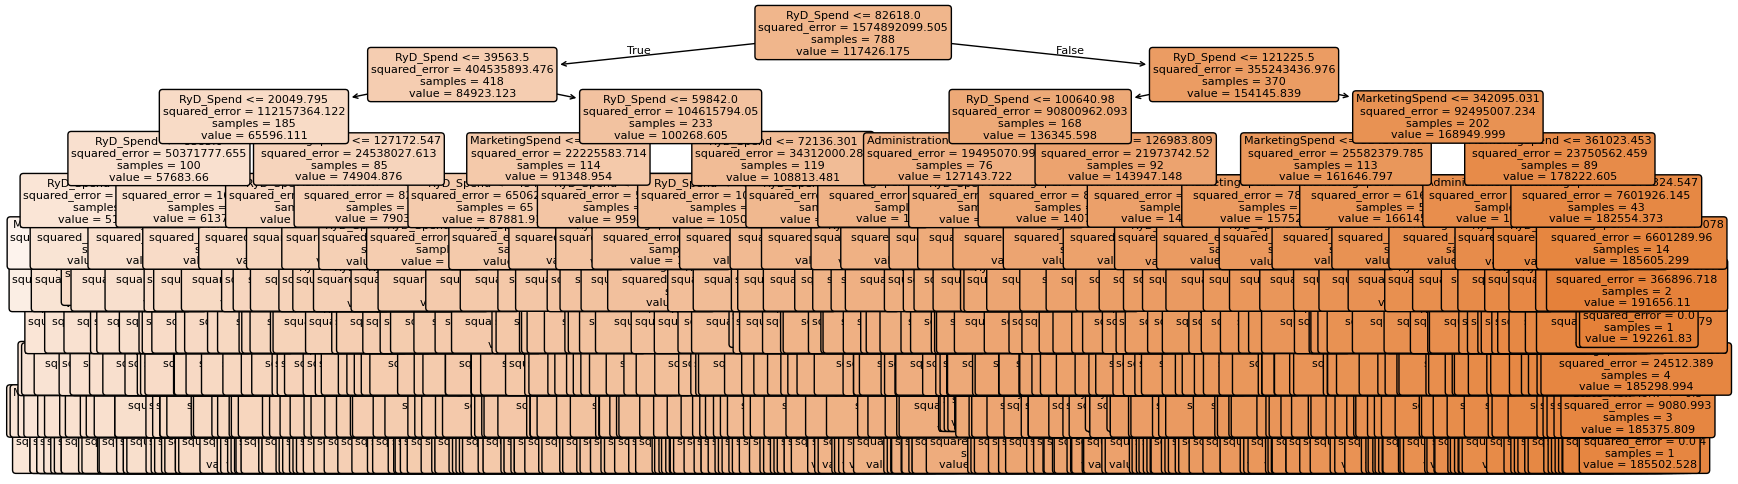

In [425]:
plt.figure(figsize=(20,6))
plot_tree(tree_reg, feature_names=X_train1.columns, fontsize=8, filled=True,
               rounded=True)
plt.show()

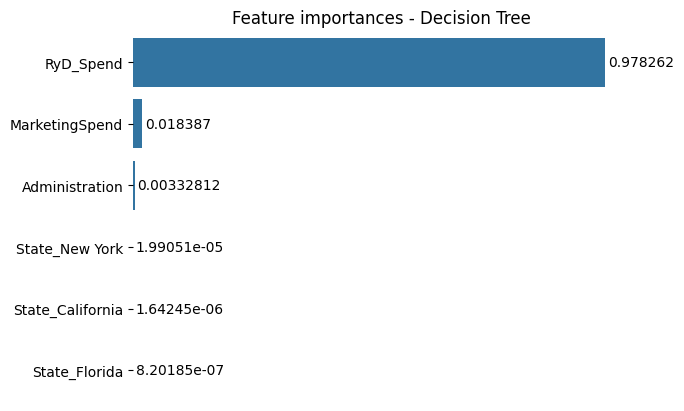

In [426]:
# Creo un df con dos columnas -> Caracteristica y ganacia de información
features_df = pd.DataFrame({'features': X_train1.columns,
                            'importances': tree_reg.feature_importances_ })

# Ordeno en base a la importancia
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features')
sns.despine(bottom = True, left = True)
g.set_title('Feature importances - Decision Tree')
g.set(xlabel=None, ylabel=None, xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

### Métricas

In [427]:
mape = np.mean(np.abs((y_test1 - pred_test) / y_test1) * 100)

print('Error absoluto medio:', mean_absolute_error(y_test1, pred_test))
print('Error medio cuadrado:', mean_squared_error(y_test1, pred_test))
print('Raíz del error medio cuadrado:', np.sqrt(mean_squared_error(y_test1, pred_test)))
print("Porcentaje de error medio absoluto (MAPE):", mape)

Error absoluto medio: 398.75692251683427
Error medio cuadrado: 4266533.666516622
Raíz del error medio cuadrado: 2065.558923516011
Porcentaje de error medio absoluto (MAPE): 0.30054587465854776


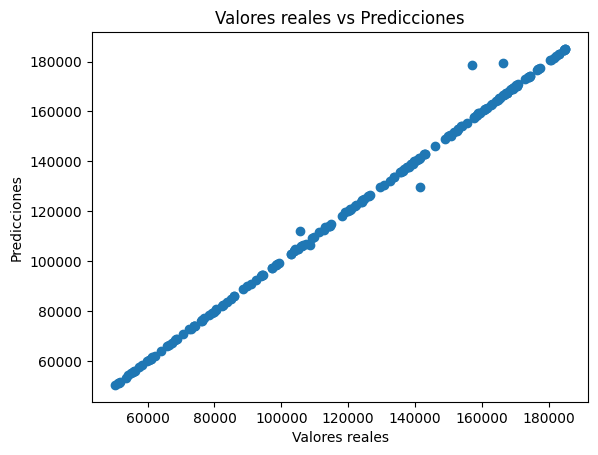

In [428]:
plt.scatter(y_test1, pred_test)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Valores reales vs Predicciones")
plt.show()

# Segundo dataset

In [429]:
dataset2 = pd.read_csv('drugType.csv')

## Análisis exploratorio de datos (EDA)

In [430]:
#Creamos copia del dataset original
df2 = dataset2.copy()

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Edad        200 non-null    int64  
 1   Sexo        200 non-null    object 
 2   BP          200 non-null    object 
 3   Colesterol  200 non-null    object 
 4   Na_a_K      200 non-null    float64
 5   Droga       200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [431]:
df2.head()

,Edad,Sexo,BP,Colesterol,Na_a_K,Droga
0,23,F,Alto,Alto,25.355,DrogaY
1,47,M,Bajo,Alto,13.093,DrogaC
2,47,M,Bajo,Alto,10.114,DrogaC
3,28,F,Normal,Alto,7.798,DrogaX
4,61,F,Bajo,Alto,18.043,DrogaY


**Valores duplicados**

In [432]:
df2.duplicated().values.any()

False

**Valores faltantes**

In [433]:
df2.isna().sum()

Edad          0
Sexo          0
BP            0
Colesterol    0
Na_a_K        0
Droga         0
dtype: int64

**Distrubuciones de las variables**

In [434]:
cols2 = ['Na_a_K', 'Edad']

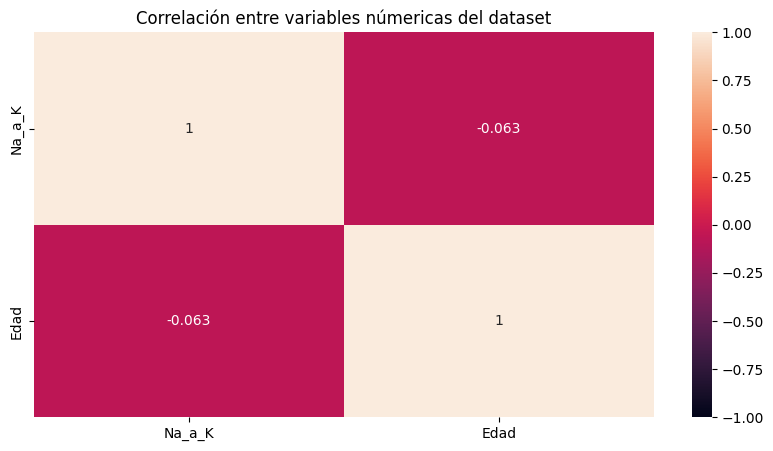

In [435]:
plt.figure(figsize=(10,5))
sns.heatmap(df2[cols2].corr(), vmin=-1, vmax=1, annot=True)
plt.title('Correlación entre variables númericas del dataset')
plt.show()

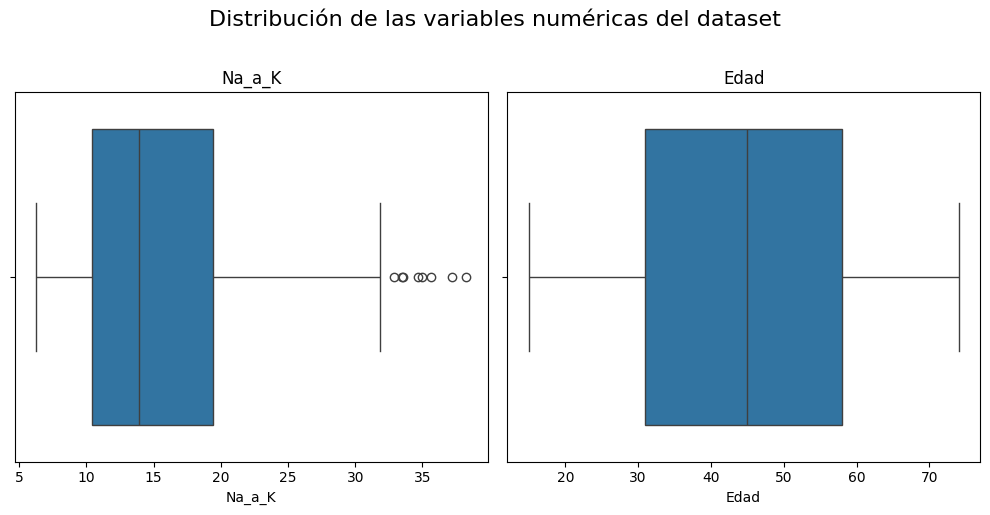

In [436]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes = axes.flatten()

for i, col in enumerate(cols2):
    sns.boxplot(x=df2[col], ax=axes[i], orient='h')
    axes[i].set_title(col)

fig.suptitle('Distribución de las variables numéricas del dataset', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

**Codificación de variables categóricas**

In [437]:
# Convertir columnas categóricas en numéricas
cat_cols = ['Sexo', 'BP', 'Colesterol']
cat_labels = [df2[col].unique().tolist() for col in cat_cols]
enc = OrdinalEncoder(categories=cat_labels).set_output(transform="pandas")
enc.fit(df2[cat_cols])
df2[cat_cols] = enc.transform(df2[cat_cols])

# Mostrar el DataFrame después de la transformación
df2.head()

,Edad,Sexo,BP,Colesterol,Na_a_K,Droga
0,23,0.0,0.0,0.0,25.355,DrogaY
1,47,1.0,1.0,0.0,13.093,DrogaC
2,47,1.0,1.0,0.0,10.114,DrogaC
3,28,0.0,2.0,0.0,7.798,DrogaX
4,61,0.0,1.0,0.0,18.043,DrogaY


**División test - train**

In [438]:
X2 = df2.drop(columns=['Droga'])
y2 = df2['Droga']

In [439]:
X_train2, X_test2, y_train2, y_test2  = train_test_split(X2, y2, test_size=0.2, random_state=13, shuffle=True, stratify=y2)
X_train3, X_test3, y_train3, y_test3  = train_test_split(X2, y2, test_size=0.3, random_state=13, shuffle=True, stratify=y2)

**Escalado de datos**

In [440]:
X_test2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 19 to 72
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Edad        40 non-null     int64  
 1   Sexo        40 non-null     float64
 2   BP          40 non-null     float64
 3   Colesterol  40 non-null     float64
 4   Na_a_K      40 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 1.9 KB


In [441]:
X_train_scaled2 = X_train2.copy()
X_test_scaled2 = X_test2.copy()

scaler = StandardScaler()

X_train_scaled2[['Edad', 'Na_a_K']] = scaler.fit_transform(X_train2[['Edad', 'Na_a_K']])
X_test_scaled2[['Edad', 'Na_a_K']] = scaler.transform(X_test2[['Edad', 'Na_a_K']])

X_train_scaled2.head()


,Edad,Sexo,BP,Colesterol,Na_a_K
83,-0.362829,0.0,0.0,1.0,-0.665798
65,1.453207,0.0,2.0,1.0,1.522411
74,-0.786571,1.0,0.0,1.0,0.133419
7,-0.181225,1.0,1.0,0.0,-0.706016
80,0.968931,1.0,0.0,0.0,-0.302859


In [442]:
X_train_scaled3 = X_train3.copy()
X_test_scaled3 = X_test3.copy()

X_train_scaled3[['Edad', 'Na_a_K']] = scaler.fit_transform(X_train3[['Edad', 'Na_a_K']])
X_test_scaled3[['Edad', 'Na_a_K']] = scaler.transform(X_test3[['Edad', 'Na_a_K']])

X_train_scaled3.head()

,Edad,Sexo,BP,Colesterol,Na_a_K
39,-1.725205,1.0,2.0,0.0,-0.990332
129,-0.699477,0.0,2.0,0.0,-1.222585
71,-0.940825,0.0,2.0,0.0,0.540342
174,-0.096108,1.0,0.0,1.0,-0.458187
125,-1.483857,0.0,0.0,1.0,1.449988


In [443]:
X_train_scaled2.shape, X_test_scaled2.shape, X_train_scaled3.shape, X_test_scaled3.shape

((160, 5), (40, 5), (140, 5), (60, 5))

## Árbol de decisión

In [444]:
tree_clf2 = DecisionTreeClassifier(criterion='gini', min_samples_leaf=1, random_state=13, class_weight= 'balanced')

tree_clf2.fit(X_train2, y_train2)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [445]:
pred_train = tree_clf2.predict(X_train2)

pred_test2 = tree_clf2.predict(X_test2)

tableResult(y_test2, pred_test2).head()

,Actual,Predicted
19,DrogaY,DrogaY
50,DrogaY,DrogaY
99,DrogaY,DrogaY
41,DrogaB,DrogaB
30,DrogaX,DrogaX


**Optimización de hiperparámetros**

In [446]:
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'max_features': [3, 5, 7, 9, 11, 13],
    'random_state': [13]
}
random_search = RandomizedSearchCV(DecisionTreeClassifier(), n_iter=18,
                                   param_distributions=param_grid)
random_search.fit(X_train2, y_train2)
# Mejores hiperparámetros encontrados durante la búsqueda aleatoria
first_best_params = random_search.best_params_
# Entrenamos el modelo con estos hiperparámetros
best_prediction = random_search.predict(X_test2)
test_accuracy = accuracy_score(y_test2, best_prediction)

print(f'{first_best_params} \n {test_accuracy}')

{'random_state': 13, 'max_features': 5, 'max_depth': 5} 
 0.975


In [447]:
#Mejor modelo
max_features = first_best_params['max_features']
max_depth = first_best_params['max_depth']

tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=max_depth, max_features=max_features,
                            min_samples_leaf=1, random_state=13, class_weight= 'balanced')

tree_clf.fit(X_train2, y_train2)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,5
,random_state,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [448]:
pred_train = tree_clf.predict(X_train2)

pred_test2 = tree_clf.predict(X_test2)

tableResult(y_test2, pred_test2).head()

,Actual,Predicted
19,DrogaY,DrogaY
50,DrogaY,DrogaY
99,DrogaY,DrogaY
41,DrogaB,DrogaB
30,DrogaX,DrogaX


**Visualización**

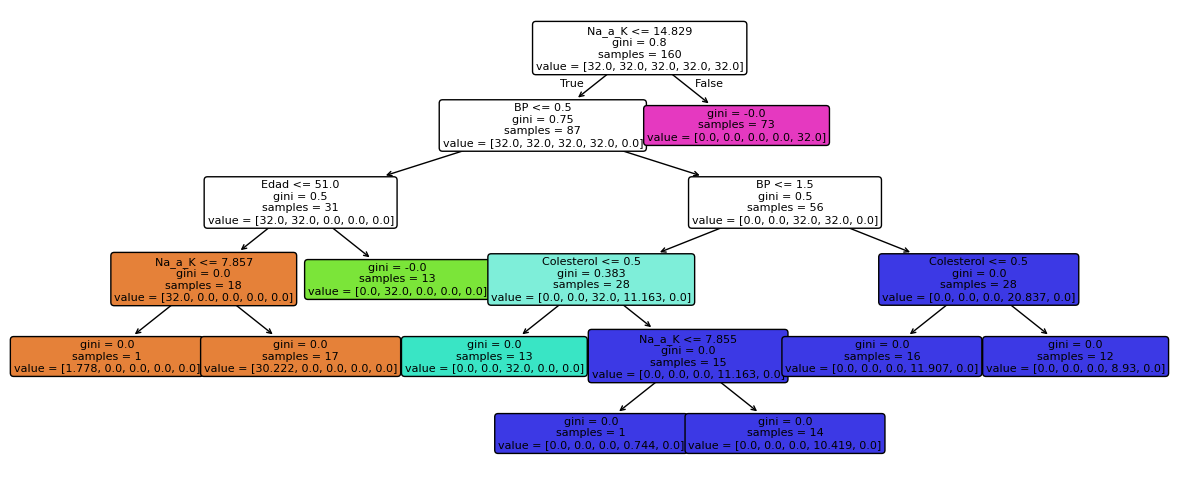

In [449]:
plt.figure(figsize=(15,6))
plot_tree(tree_clf2, feature_names=X_train2.columns, fontsize=8, filled=True,
               rounded=True)
plt.show()

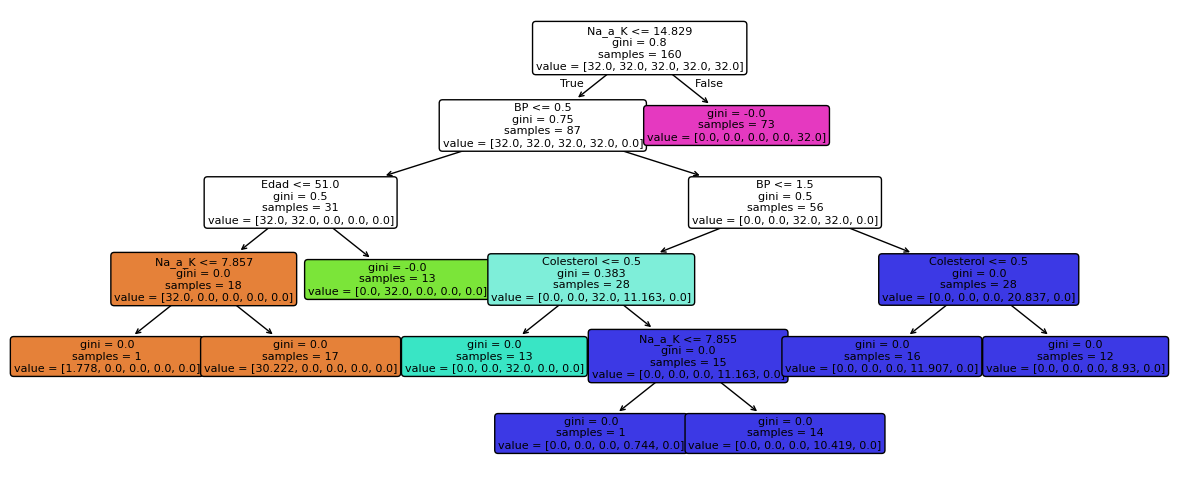

In [450]:
plt.figure(figsize=(15,6))
plot_tree(tree_clf, feature_names=X_train2.columns, fontsize=8, filled=True,
               rounded=True)
plt.show()

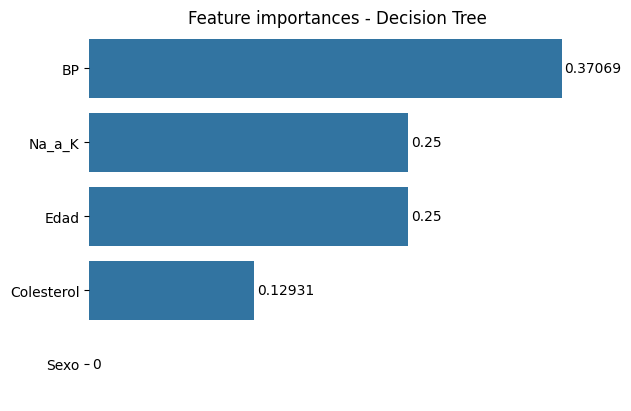

In [451]:
# Creo un df con dos columnas -> Caracteristica y ganacia de información
features_df = pd.DataFrame({'features': X_train2.columns,
                            'importances': tree_clf.feature_importances_ })

# Ordeno en base a la importancia
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features')
sns.despine(bottom = True, left = True)
g.set_title('Feature importances - Decision Tree')
g.set(xlabel=None, ylabel=None, xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

**Métricas**

In [452]:
print('Accuracy:', accuracy_score(y_test2, pred_test2))
print('Presision:', precision_score(y_test2, pred_test2, average='weighted'))
print('Recall:', recall_score(y_test2, pred_test2, average='weighted'))
print("F1:", f1_score(y_test2, pred_test2, average='weighted'))

Accuracy: 0.975
Presision: 0.9791666666666667
Recall: 0.975
F1: 0.9736363636363636


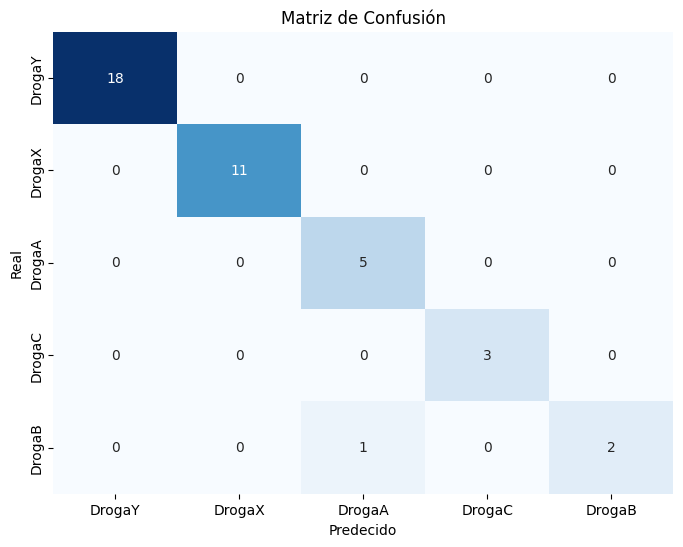

In [453]:
confusion = confusion_matrix(y_test2, pred_test2, labels=['DrogaY', 'DrogaX', 'DrogaA', 'DrogaC', 'DrogaB'])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=['DrogaY', 'DrogaX', 'DrogaA', 'DrogaC', 'DrogaB'],
            yticklabels=['DrogaY', 'DrogaX', 'DrogaA', 'DrogaC', 'DrogaB'],
            cbar=False)
plt.xlabel('Predecido')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Bayes 

In [454]:
clf_GNB = GaussianNB()
clf_GNB.fit(X_train_scaled2, y_train2)

,priors,None
,var_smoothing,1e-09


In [455]:
pred_GNB = clf_GNB.predict(X_test_scaled2)

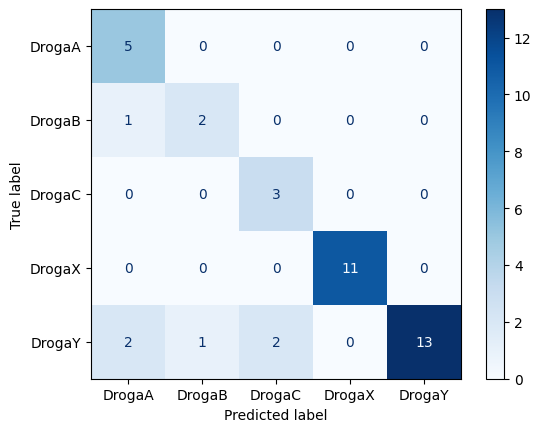

In [456]:
ConfusionMatrixDisplay.from_predictions(y_test2, pred_GNB, cmap=plt.cm.Blues)